## Training

In [1]:
try:
  import tf_agents
except ImportError:
  %pip install tf-agents
  %pip install tf-keras

2025-07-19 16:22:08.618046: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 16:22:08.644325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-19 16:22:08.644343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-19 16:22:08.645027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-19 16:22:08.649482: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option('display.float_format', lambda x: '%.4f' % x)

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.policies import policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

from trading_utils import preprocess_data, create_wide_format_data, SYMBOLS
from trading_env import CryptoTradingEnvironment

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Data and Model Paths
DATA_FILEPATH = 'data/ohlcv.csv.gz'
POLICY_SAVE_PATH = 'policy'

# Model Hyperparameters
CONTEXT_LENGTH = 10
NUM_TRAINING_STEPS = 10000  # Increased for more meaningful training
ALPHA = 1.0 # LinUCB exploration parameter
TEST_SIZE = 0.2

TECHNICAL_FEATURES = ['price_change', 'volume_change', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_percent_b', 'bb_bandwidth']

# Load Data
df = pd.read_csv(DATA_FILEPATH, compression='gzip', parse_dates=['timestamp']) #.set_index('timestamp')
all_data = preprocess_data(df)
observation_df, prices_df = create_wide_format_data(
    all_data, 
    symbols=SYMBOLS, 
    features=TECHNICAL_FEATURES
)

print(f"all_data: {len(all_data)}")

train_observation_df, test_observation_df = train_test_split(
    observation_df, 
    test_size=TEST_SIZE, 
    shuffle=False
)

train_prices_df, test_prices_df = train_test_split(
    prices_df, 
    test_size=TEST_SIZE, 
    shuffle=False
)

scaler = StandardScaler()
train_observation_scaled_df = pd.DataFrame(scaler.fit_transform(train_observation_df), columns=train_observation_df.columns, index=train_observation_df.index)
test_observation_scaled_df = pd.DataFrame(scaler.transform(test_observation_df), columns=train_observation_df.columns, index=test_observation_df.index)

print(f"observation training data: {train_observation_scaled_df.shape}")
display(train_observation_scaled_df.head(5))

print(f"price training data: {train_prices_df.shape}")
display(train_prices_df.head(5))

all_data: 111560
observation training data: (17849, 40)


,BTC_price_change,BTC_volume_change,BTC_rsi,BTC_macd,BTC_macd_signal,BTC_macd_hist,BTC_bb_percent_b,BTC_bb_bandwidth,DOGE_price_change,DOGE_volume_change,...,ETH_bb_percent_b,ETH_bb_bandwidth,SOL_price_change,SOL_volume_change,SOL_rsi,SOL_macd,SOL_macd_signal,SOL_macd_hist,SOL_bb_percent_b,SOL_bb_bandwidth
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 19:00:00,0.1105,-0.0075,0.2817,-0.0525,-0.0763,0.0640,1.7346,-1.0184,0.0003,-0.0075,...,1.7207,-0.9623,-0.3214,-0.0075,0.9613,-0.0611,-0.0812,0.0513,0.6489,-0.5508
2023-01-01 20:00:00,-0.0049,-0.0075,0.3061,-0.0459,-0.0707,0.0686,1.4830,-0.9919,0.1283,-0.0075,...,1.3709,-0.9386,-0.0214,-0.0075,0.9613,-0.0569,-0.0770,0.0521,0.6656,-0.5610
2023-01-01 21:00:00,0.0038,-0.0075,0.3629,-0.0407,-0.0651,0.0684,1.3207,-0.9645,-0.1275,-0.0075,...,1.4988,-0.8976,0.0789,-0.0075,0.9613,-0.0529,-0.0728,0.0521,0.8205,-0.6040
2023-01-01 22:00:00,-0.0756,-0.0075,0.1982,-0.0385,-0.0602,0.0604,1.0542,-0.9464,-0.3124,-0.0075,...,0.9188,-0.8847,-0.1216,-0.0075,0.8424,-0.0505,-0.0689,0.0479,0.7854,-0.6378
2023-01-01 23:00:00,0.1509,-0.0075,0.5874,-0.0336,-0.0552,0.0608,1.2332,-0.9256,0.1429,-0.0075,...,0.6728,-0.8879,0.1793,-0.0075,0.9222,-0.0474,-0.0652,0.0465,0.9515,-0.6259


price training data: (17849, 5)


symbol,BTC,DOGE,XRP,ETH,SOL
timestamp,,,,,
2023-01-01 19:00:00,16603.0800,0.0703,0.3390,1201.7800,9.9700
2023-01-01 20:00:00,16604.5100,0.0704,0.3387,1201.4000,9.9700
2023-01-01 21:00:00,16606.6800,0.0703,0.3386,1202.8500,9.9800
2023-01-01 22:00:00,16602.1200,0.0701,0.3386,1201.0300,9.9700
2023-01-01 23:00:00,16616.7500,0.0702,0.3387,1200.3400,9.9900


In [3]:
# Setup Environment
crypto_env = CryptoTradingEnvironment(
    observation_df=train_observation_scaled_df,
    prices_df=train_prices_df,
    symbols=SYMBOLS
)

tf_env = tf_py_environment.TFPyEnvironment(crypto_env)

# Setup Agent
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    alpha=ALPHA,
    dtype=tf.float32
)

# Setup Metrics and Oracle
def optimal_reward_oracle(observation: np.ndarray) -> np.float32:
    """
    Calculates the best possible reward for the current step by looking ahead.
    This "perfect foresight" oracle is used for calculating regret.

    NOTE: The 'observation' argument is unused but required by the metric's API.
    """
    # 1. Get the env
    py_env = tf_env.pyenv.envs[0]
    
    # 2. Get the current step index from the environment's state.
    current_step = py_env.current_step
    price_data = py_env.price_data

    
    # 3. Handle the edge case where we are at the end of the data.
    # We can't look one step into the future.
    if current_step >= len(price_data) - 1:
        return 0.0

    # 4. Calculate the reward for every possible action to find the maximum.
    all_possible_rewards = []
    num_actions = py_env.action_spec().maximum + 1
    
    for action in range(num_actions):
        # Decode the action into a symbol and a trade type
        crypto_index = action // 3
        trade_type_idx = action % 3  # 0: BUY, 1: HOLD, 2: SELL
        
        # The reward for a HOLD action is always 0.
        if trade_type_idx == 1:
            all_possible_rewards.append(0.0)
            continue
            
        symbol_to_trade = py_env.symbols[crypto_index]
        
        current_price = price_data.iloc[current_step][symbol_to_trade]
        next_price = price_data.iloc[current_step + 1][symbol_to_trade]
        # next_price_change = price_data.iloc[current_step + 1][symbol_to_trade]

        
        # Calculate the reward for this specific BUY or SELL action
        if trade_type_idx == 0:  # BUY
            reward = (next_price - current_price) / current_price
        else:  # SELL (trade_type_idx == 2)
            reward = (current_price - next_price) / current_price
        
        all_possible_rewards.append(reward)
        
    # 5. Return the maximum possible reward from all actions.
    return np.max(all_possible_rewards).astype(np.float32)

class ShowProgress:
    def __init__(self, total, interval=50):
        self.counter = 0
        self.total = total
        self.interval = interval
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % self.interval == 0:
            print("\r{}/{} Reward: {}".format(self.counter, self.total, np.round(trajectory.reward.numpy()[0], 6)), end="")

class MetricsObserver:
    def __init__(self, oracle_fn):
        self._oracle_fn = oracle_fn
        self.rewards = []
        self.regrets = []
        self.optimal_rewards = []

    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            reward = trajectory.reward.numpy()[0]
            optimal_reward = self._oracle_fn(trajectory.observation)
            regret = optimal_reward - reward
            
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.optimal_rewards.append(optimal_reward)

    def cum_rewards(self):
        cumulative_reward = np.cumsum(self.rewards)
        cumulative_optimal_reward = np.cumsum(self.optimal_rewards)
        return cumulative_reward, cumulative_optimal_reward

    def cum_averages(self):
        steps = np.arange(len(self.rewards)) + 1
        cumulative_avg_reward = np.cumsum(self.rewards) / steps
        cumulative_avg_optimal_reward = np.cumsum(self.optimal_rewards) / steps
        cumulative_avg_regret = np.cumsum(self.regrets) / steps
        return cumulative_avg_reward, cumulative_avg_optimal_reward, cumulative_avg_regret
        

def train_step(trajectory):
    if not trajectory.is_last():
        time_axised_trajectory = tf.nest.map_structure(lambda t: tf.expand_dims(t, 1), trajectory)
        agent.train(time_axised_trajectory)
        
metrics_observer = MetricsObserver(optimal_reward_oracle)

# 5. Setup Driver
# Set num_steps to the total number of steps you want to train for.
num_steps_to_train = min(len(train_observation_scaled_df) - 1, NUM_TRAINING_STEPS)

driver = dynamic_step_driver.DynamicStepDriver(
    env=tf_env,
    policy=agent.policy,
    num_steps=num_steps_to_train,
    observers=[train_step, metrics_observer, ShowProgress(num_steps_to_train)]
)

print(f"\nStarting training for {num_steps_to_train} steps...")
driver.run()
print("Training finished.")

# Save Policy
print(f"\nSaving the trained policy to: {POLICY_SAVE_PATH}")
saver = policy_saver.PolicySaver(agent.policy)
saver.save(POLICY_SAVE_PATH)
print("Policy saved successfully.")

2025-07-19 16:22:11.037212: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-19 16:22:11.044834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-19 16:22:11.047862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-


Starting training for 10000 steps...
10000/10000 Reward: 0.0Training finished.

Saving the trained policy to: policy


INFO:tensorflow:Assets written to: policy/assets


/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: policy/assets


Policy saved successfully.


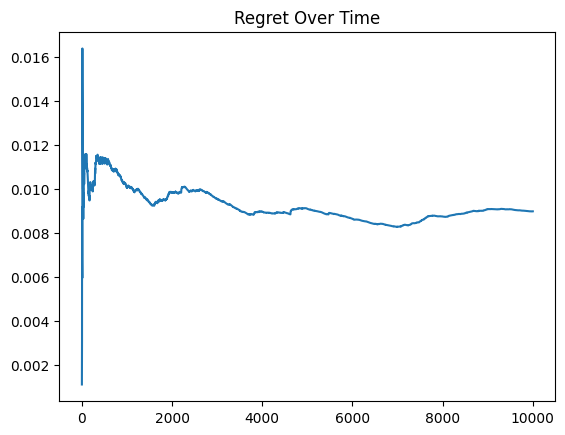

In [4]:
cumulative_avg_reward, cumulative_avg_optimal_reward, cumulative_avg_regret = metrics_observer.cum_averages()

plt.plot(cumulative_avg_regret)
plt.title('Cumulative Average Regret Over Time')
plt.show()

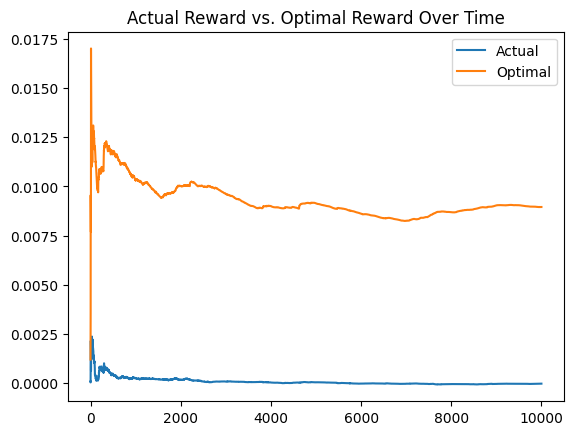

In [5]:
plt.plot(cumulative_avg_reward, label='Actual')
plt.plot(cumulative_avg_optimal_reward, label='Optimal')
plt.title('Actual vs. Optimal Cumulative Average Reward Over Time')
plt.legend()
plt.show()

In [ ]:
cumulative_reward, cumulative_optimal_reward = metrics_observer.cum_rewards()

plt.plot(cumulative_reward, label='Actual')
plt.plot(cumulative_optimal_reward, label='Optimal')
plt.title('Actual vs. Optimal Cumulative Reward Over Time')
plt.legend()
plt.show()